In [2]:
# install packages
! pip install pandas==1.1.5
! pip install xgboost==1.4.2
! pip install numpy==1.19.5

In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import precision_recall_curve, average_precision_score

import pickle
import os

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [3]:
path = os.getcwd()

# Check if running in Colab
try:
  from google.colab import drive
  IN_COLAB=True
  print("Running in Colab")
  # Mount Google Drive 
  drive.mount('/content/drive')
  # Change directory
  path = /content/drive/My \Drive/BitterMatch
  %cd /content/drive/My \Drive/BitterMatch_Reviewers_test
except:
  IN_COLAB=False
  print("Running locally")

Running in Colab
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/BitterMatch


In [4]:
from similarity import *
from preprocessing import *

## 1. Load data and pre-process to obtain inputs

To train the model the following input is required:
* $A \in \mathbb{R}^{L \times R}$ - An association matrix between $L$ ligands and $R$ receptors
* $X^{\text{Rec}}$ - A matrix of receptor features (each row corresponding to a receptor)
* $X^{\text{Lig}}$ - A matrix of ligand features (each row corresponding to a ligand)
* $S^{\text{Rec}}_1, \dots, S^{\text{Rec}}_k$ - Precomputed similarity matrices between receptors 
* $S^{\text{Lig}}_1, \dots, S^{\text{Lig}}_m$ - Precomputed similarity matrices between ligands 


Here we provide helper functions to obtain these inputs from the formats listed in the paper.
If the inputs are obtained from a different source the first section should be skipped or replaced.

Load and prepare $A, X^{\text{Rec}}, X^{\text{Lig}}$

In [5]:
A = load_A('Data/bitterdb_associations.csv')

# remove orphan receptors from association matrix
orphan_receptors = A.columns[np.sum(A, axis=0)==0]
A = A[A.columns[~np.isin(A.columns, orphan_receptors)]]

In [6]:
X_Rec = load_X_Rec('Data/receptor_features.csv')

# remove orphan receptors from receptor features matrix
X_Rec = X_Rec[~np.isin(X_Rec.column_label, orphan_receptors)]

In [8]:
X_Lig = load_X_Lig('Data/ligand_features.csv')

Load and prepare $S^{\text{Rec}}_1, \dots, S^{\text{Rec}}_4$

In [9]:
Rec_sim = read_receptor_similarity('Data/Columns_similarity_matrix.csv')
Rec_ident = read_receptor_similarity('Data/Columns_identity_matrix.csv')
Rec_sites_sim = read_receptor_similarity('Data/Col_Similarity_Bindingsite.csv')
Rec_sites_ident = read_receptor_similarity('Data/Col_Identity_Bindingsites.csv')

Load and prepare $S^{\text{Lig}}_1, S^{\text{Lig}}_2$

In [10]:
Lig_linear_sim = read_ligand_similarity('Data/Ligand_Linear_Similarity.csv') 
Lig_mol2d_sim = read_ligand_similarity('Data/Ligand_mol2D_Similarity.csv')

## 2. Prepare feature matrix

In [11]:
# create data frame of all pairs of ligand-receptor
pairs = pd.melt(A.assign(ligand=A.index), id_vars='ligand', var_name='receptor', value_name='association')
pairs['test'] = np.isnan(pairs.association)

### 2.1 Add chemical properties of ligands and receptors

In [12]:
# cross join ligand and receptor data
features_df = pd.merge(X_Lig.rename(columns=lambda r: 'Lig_%s' % r).assign(key_=1),
                       X_Rec.rename(columns=lambda c: 'Rec_%s' % c).assign(key_=1),
                       on='key_').drop('key_', 1)
features_df = features_df.rename(columns={'Lig_cid': 'ligand', 'Rec_column_label': 'receptor'})
#features_df.drop('Lig_Unnamed: 0', inplace=True, axis=1)

# add a feature indicating whether the receptor is human
features_df['is_human_receptor'] = features_df.receptor<2000

# add association (ground truth) and train/test split
features_df = features_df.merge(pairs, how='outer', on=['ligand', 'receptor'])

#### 2.3.1 Extract similarity based metrics
$W_{l1}$ -  average similarity of the ligand $l$ to ligands $l'$ that associate with a receptor $r$ <br />
$W_{l0}$ - average similarity of the ligand $l$ to ligands $l'$ that do not associate with a receptor $r$  <br /> 
$M_{l1}$  - similarity between the ligand $l$  and the most similar ligand that associates with a receptor  r <br />
$M_{l0}$  - similarity between the ligand $l$  and the most similar ligand that does not associate with a receptor  r <br />

$W_{r1}$ - average similarity of the receptor $r$ to receptors $r'$ that  associate with the ligand $l$ <br />
$W_{r0}$ - average similarity of the receptor $r$ to receptors $r'$ that  do not associate with the ligand $l$ <br />
$M_{r1}$ - similarity between the receptor $r$  and the most similar receptor that associates with a ligand $l$  <br />
$M_{r0}$ - similarity between the receptor $r$  and the most similar receptor that does not associate with a ligand $l$ <br />

In [13]:
sim_metrics_dict = {'Lig_linear_sim':       (Lig_linear_sim,   0),
                    'Lig_mol2d_sim':        (Lig_mol2d_sim,    0),
                    'Rec_sim':              (Rec_sim,          1),
                    'Rec_sim_sites':        (Rec_sites_sim,    1),
                    'Rec_ident':            (Rec_ident,        1),
                    'Rec_ident_sites':      (Rec_sites_ident,  1)}

In [14]:
# add similarity based features to the features data frame
for prefix, (sim_df, axis) in sim_metrics_dict.items():
    sim_metrics_df = sim_metrics(sim_df, A, axis).rename(columns=lambda receptor: '%s_%s' % (prefix, receptor))
    features_df = features_df.merge(sim_metrics_df, how='outer', on=['ligand', 'receptor'])

### 2.3 Create $X^{\text{Test}}$ matrix

In [15]:
results_df = features_df[(features_df.test == True)]
X_test = results_df.drop(['ligand', 'receptor', 'association', 'test'], axis=1)

results_df = results_df[['ligand', 'receptor']]

## 3. Predict

In [16]:
xgb_clf = xgb.XGBClassifier(objective = 'binary:logistic',  booster = 'gbtree')

In [18]:
xgb_model = pickle.load(open("Trained_Models/trained_model_no_3.pkl", "rb"))

In [19]:
Y_pred = xgb_model.predict_proba(X_test)

In [20]:
results_df["pred_prob"] = Y_pred[:,1]

In [21]:
prior = np.sum(A, axis=0)/np.sum(~np.isnan(A),axis=0)
results_df = results_df.join(prior.rename('prior'), on=["receptor"], how="left")
results_df = results_df.sort_values(by='pred_prob', ascending=False)

#### Calibrating probabilities

In [23]:
from sklearn.linear_model import LogisticRegression

In [25]:
_, _, _, _, Y_test, Y_hat =  pickle.load(open("Trained_Models/data_for_trained_model_no_3.pkl", "rb"))

In [26]:
logistic_clf = LogisticRegression().fit(Y_hat[:,1].reshape(-1,1), Y_test.reshape(-1,1))
calibrated_Y_hat = logistic_clf.predict_proba(Y_hat[:,1].reshape(-1,1))
prob = results_df.pred_prob.values.reshape(-1,1)
calibrated_prob = logistic_clf.predict_proba(prob)
results_df['clibrated_prob'] = calibrated_prob[:,1]

## Plots

In [27]:
pred_A = results_df.pivot(index='ligand', columns='receptor')['clibrated_prob']

In [28]:
test_pairs = results_df[['ligand', 'receptor', 'clibrated_prob']]
test_pairs = test_pairs.rename(columns={"clibrated_prob": "association"})

In [29]:
train_pairs = pairs[pairs.test==False][['ligand', 'receptor', 'association']]

In [30]:
full_pairs = pd.concat([train_pairs, test_pairs])
full_A = full_pairs.pivot(index='ligand', columns='receptor')['association']

The heat-maps below show the the asociation matrix, before and after filling the gaps. On the the left side (before), missing values are shown in grey. On the right side (after) missing values are completed with the model's prediction and colored according to the predicted probabilities of the ligands to activate each receptor.

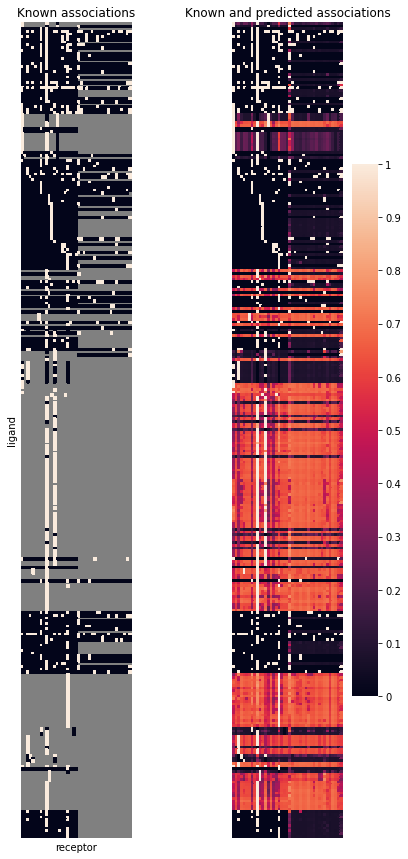

In [31]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(7, 15))

g = sns.heatmap(A, square=True, yticklabels=[], xticklabels=[], ax=ax1, cbar=False)
g.set_facecolor('grey')
g.set_xlabel('receptor')
g.set_ylabel('ligand')
g.set_title('Known associations')

h = sns.heatmap(full_A, square=True, yticklabels=[], xticklabels=[], ax=ax2)
h.set_facecolor('grey')
h.set_xlabel('')
h.set_ylabel('')
h.set_title('Known and predicted associations')


cbar = ax2.collections[0].colorbar
cbar.set_ticks([0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1])
cbar.set_ticklabels([0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1])